### MATH7017 Prababilistic Graphical Models
### ---Final Project---
#### Student Name - Gauri Ratawal
#### Student ID - 22032967

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


#### Importing Libraries:

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

#### Creating C-GAN Architecture:

In [4]:
# Checking if we have a GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the Conditional Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, label_dim, style_dim, img_dim):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(latent_dim + label_dim + style_dim, 256),
            nn.ReLU(),
            nn.Linear(256, img_dim),
            nn.Tanh(),  # Because we normalize images to be between -1 and 1
        )

    def forward(self, noise, labels, styles):
        x = torch.cat([noise, labels, styles], dim=1)
        return self.gen(x)

# Define the Conditional Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_dim, label_dim, style_dim):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_dim + label_dim + style_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img, labels, styles):
        x = torch.cat([img, labels, styles], dim=1)
        return self.disc(x)

#### Initializing Model:

In [5]:
# Hyperparameters
latent_dim = 100
label_dim = 49
style_dim = 1
img_dim = 784  # 28x28 images flattened
batch_size = 128
lr = 0.001
epochs = 100

# Instantiate the generator and discriminator
generator = Generator(latent_dim, label_dim, style_dim, img_dim).to(device)
discriminator = Discriminator(img_dim, label_dim, style_dim).to(device)

# Optimizers
opt_gen = torch.optim.Adam(generator.parameters(), lr=lr)
opt_disc = torch.optim.Adam(discriminator.parameters(), lr=lr)

# Loss function
criterion = nn.BCELoss()

#### Loading and processing data sets for training:

In [6]:
# Load the Kuzushiji-49 dataset
train_imgs = np.load('k49-train-imgs.npz')['arr_0']
train_labels = np.load('k49-train-labels.npz')['arr_0']
train_styles = np.load('k49-train-style.npz')['styles']
test_imgs = np.load('k49-test-imgs.npz')['arr_0']
test_labels = np.load('k49-test-labels.npz')['arr_0']
test_styles = np.load('k49-test-style.npz')['styles']

# Normalize images
train_imgs = train_imgs.astype('float32') / 255.
test_imgs = test_imgs.astype('float32') / 255.

# Flatten images
train_imgs = train_imgs.reshape(-1, 784)
test_imgs = test_imgs.reshape(-1, 784)

# Convert to PyTorch tensors
train_imgs = torch.tensor(train_imgs, dtype=torch.float32)
test_imgs = torch.tensor(test_imgs, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)
train_styles = torch.tensor(train_styles, dtype=torch.float32).reshape(-1, 1)
test_styles = torch.tensor(test_styles, dtype=torch.float32).reshape(-1, 1)

# One-hot encode labels
train_labels_one_hot = F.one_hot(train_labels, num_classes=49).float()
test_labels_one_hot = F.one_hot(test_labels, num_classes=49).float()

# Create DataLoader
train_dataset = TensorDataset(train_imgs, train_labels_one_hot, train_styles)
test_dataset = TensorDataset(test_imgs, test_labels_one_hot, test_styles)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Training C-GAN Model:

In [7]:
# Lists to store losses and accuracies
train_losses = []
gen_losses = []
disc_losses = []
train_accuracies = []
test_accuracies = []

# Training and evaluation functions
def train(epoch):
    generator.train()
    discriminator.train()
    train_loss = 0
    gen_loss_epoch = 0
    disc_loss_epoch = 0
    correct = 0
    total = 0
    for batch_idx, (real, labels, styles) in enumerate(train_loader):
        real = real.to(device)
        labels = labels.to(device)
        styles = styles.to(device)
        batch_size = real.shape[0]

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, latent_dim).to(device)
        fake = generator(noise, labels, styles)

        disc_real = discriminator(real, labels, styles).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))

        disc_fake = discriminator(fake.detach(), labels, styles).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

        lossD = (lossD_real + lossD_fake) / 2
        discriminator.zero_grad()
        lossD.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z)))
        output = discriminator(fake, labels, styles).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        generator.zero_grad()
        lossG.backward()
        opt_gen.step()

        train_loss += lossD.item()
        gen_loss_epoch += lossG.item()
        disc_loss_epoch += lossD.item()

        # Calculate accuracy
        pred = disc_real > 0.5
        correct += pred.eq(torch.ones_like(pred)).sum().item()
        total += pred.size(0)

    train_accuracy = 100. * correct / total
    train_losses.append(train_loss / len(train_loader))
    gen_losses.append(gen_loss_epoch / len(train_loader))
    disc_losses.append(disc_loss_epoch / len(train_loader))
    train_accuracies.append(train_accuracy)

    print(f'Epoch [{epoch+1}/{epochs}] Loss D: {lossD:.4f}, loss G: {lossG:.4f}, Train Accuracy: {train_accuracy:.2f}%')

def test(epoch):
    generator.eval()
    discriminator.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for real, labels, styles in test_loader:
            real = real.to(device)
            labels = labels.to(device)
            styles = styles.to(device)
            batch_size = real.shape[0]
            noise = torch.randn(batch_size, latent_dim).to(device)
            fake = generator(noise, labels, styles)

            disc_real = discriminator(real, labels, styles).view(-1)
            disc_fake = discriminator(fake, labels, styles).view(-1)

            lossD_real = criterion(disc_real, torch.ones_like(disc_real))
            lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
            lossD = (lossD_real + lossD_fake) / 2
            test_loss += lossD.item()

            # Calculate accuracy
            pred = disc_real > 0.5
            correct += pred.eq(torch.ones_like(pred)).sum().item()
            total += pred.size(0)

    test_accuracy = 100. * correct / total
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{epochs}] Test set loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


In [8]:
# Visualize generated images
def visualize_generated_images(model, epoch, num_images=49):
    model.eval()
    labels = torch.arange(0, label_dim).repeat_interleave(num_images // label_dim).to(device)
    labels_one_hot = F.one_hot(labels, num_classes=label_dim).float().to(device)
    styles = torch.tensor([1] * num_images).reshape(-1, 1).to(device)  # Use 'thick' style
    z = torch.randn(num_images, latent_dim).to(device)
    with torch.no_grad():
        generated_imgs = model(z, labels_one_hot, styles).cpu()

    fig, axes = plt.subplots(7, 7, figsize=(10, 10))
    for i in range(49):
        ax = axes[i // 7, i % 7]
        ax.imshow(generated_imgs[i].view(28, 28), cmap='gray', interpolation='none')
        ax.axis('off')
    plt.suptitle(f"Generated Images at Epoch {epoch}", fontsize=16)
    plt.show()

Epoch [1/100] Loss D: 0.6253, loss G: 1.0240, Train Accuracy: 68.53%
Epoch [1/100] Test set loss: 181.6027, Test Accuracy: 70.16%


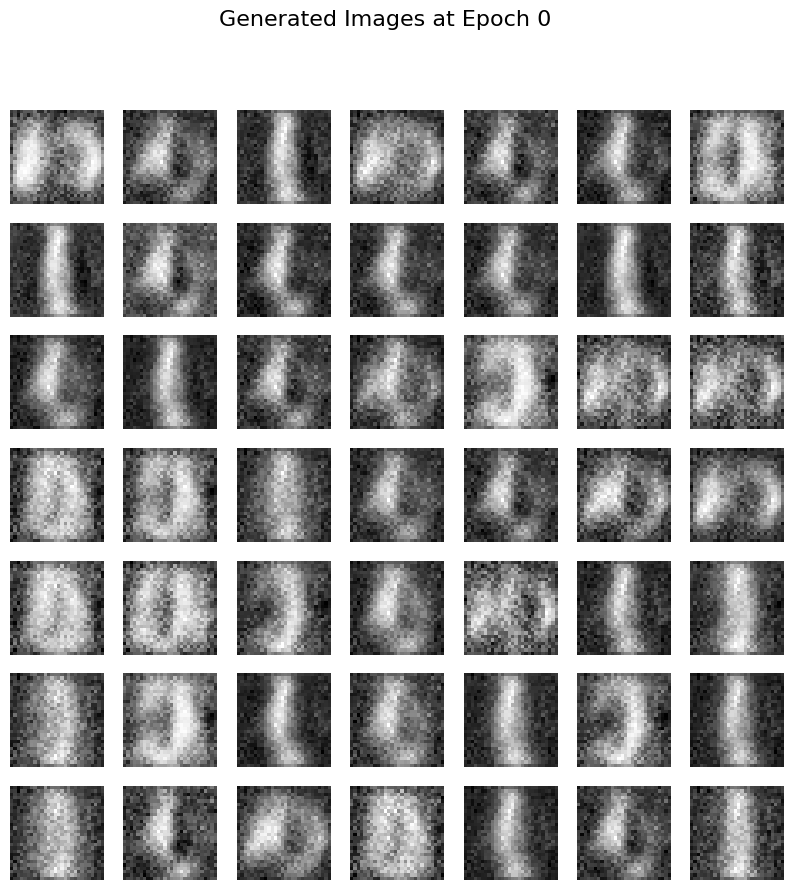

Epoch [2/100] Loss D: 0.5002, loss G: 2.2923, Train Accuracy: 67.46%
Epoch [2/100] Test set loss: 141.1948, Test Accuracy: 81.65%
Epoch [3/100] Loss D: 0.6179, loss G: 1.1272, Train Accuracy: 73.13%
Epoch [3/100] Test set loss: 198.5641, Test Accuracy: 69.74%
Epoch [4/100] Loss D: 0.5114, loss G: 2.0818, Train Accuracy: 74.68%
Epoch [4/100] Test set loss: 183.8900, Test Accuracy: 69.42%
Epoch [5/100] Loss D: 0.6755, loss G: 1.4163, Train Accuracy: 77.40%
Epoch [5/100] Test set loss: 231.7318, Test Accuracy: 58.54%
Epoch [6/100] Loss D: 0.3460, loss G: 2.4200, Train Accuracy: 77.36%
Epoch [6/100] Test set loss: 112.0715, Test Accuracy: 78.70%
Epoch [7/100] Loss D: 0.4956, loss G: 1.6813, Train Accuracy: 76.96%
Epoch [7/100] Test set loss: 143.7974, Test Accuracy: 76.33%
Epoch [8/100] Loss D: 0.2126, loss G: 2.7804, Train Accuracy: 77.38%
Epoch [8/100] Test set loss: 93.8713, Test Accuracy: 84.51%
Epoch [9/100] Loss D: 0.3157, loss G: 2.2167, Train Accuracy: 78.73%
Epoch [9/100] Test set

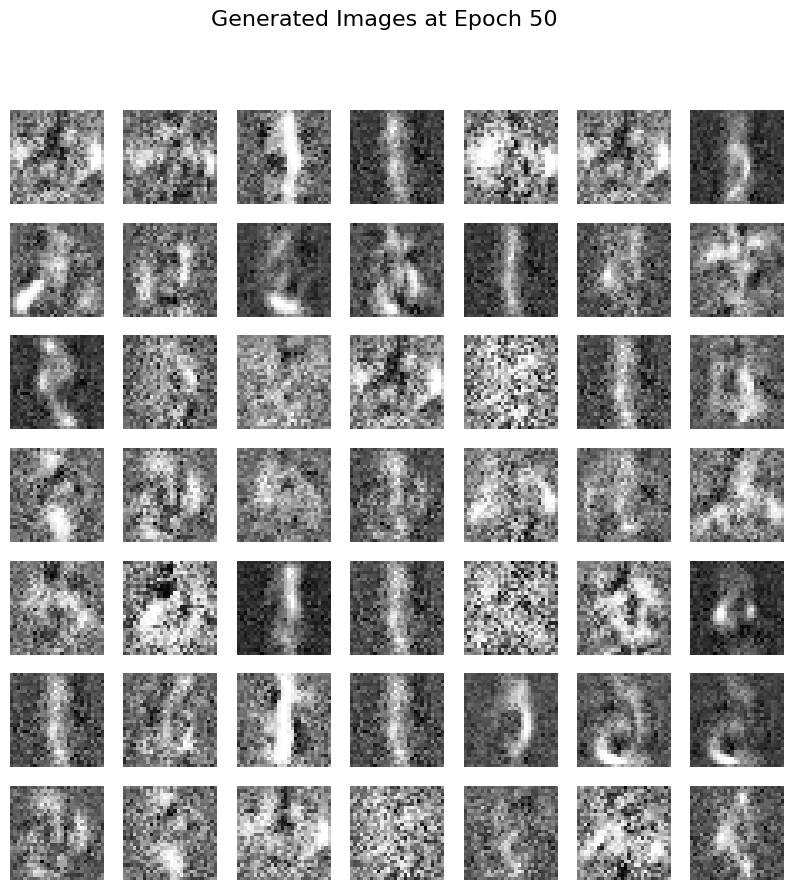

Epoch [52/100] Loss D: 0.5236, loss G: 2.1794, Train Accuracy: 68.57%
Epoch [52/100] Test set loss: 174.1571, Test Accuracy: 72.24%
Epoch [53/100] Loss D: 0.4339, loss G: 1.6252, Train Accuracy: 64.61%
Epoch [53/100] Test set loss: 155.3416, Test Accuracy: 69.90%
Epoch [54/100] Loss D: 0.6444, loss G: 1.3975, Train Accuracy: 67.90%
Epoch [54/100] Test set loss: 158.1046, Test Accuracy: 69.56%
Epoch [55/100] Loss D: 0.4269, loss G: 2.0950, Train Accuracy: 73.17%
Epoch [55/100] Test set loss: 172.4760, Test Accuracy: 67.69%
Epoch [56/100] Loss D: 0.4825, loss G: 1.5577, Train Accuracy: 70.57%
Epoch [56/100] Test set loss: 167.7320, Test Accuracy: 61.59%
Epoch [57/100] Loss D: 0.3936, loss G: 2.3013, Train Accuracy: 66.86%
Epoch [57/100] Test set loss: 145.2876, Test Accuracy: 72.73%
Epoch [58/100] Loss D: 0.4492, loss G: 1.2759, Train Accuracy: 70.11%
Epoch [58/100] Test set loss: 156.6071, Test Accuracy: 62.56%
Epoch [59/100] Loss D: 0.4749, loss G: 1.4863, Train Accuracy: 69.70%
Epoch 

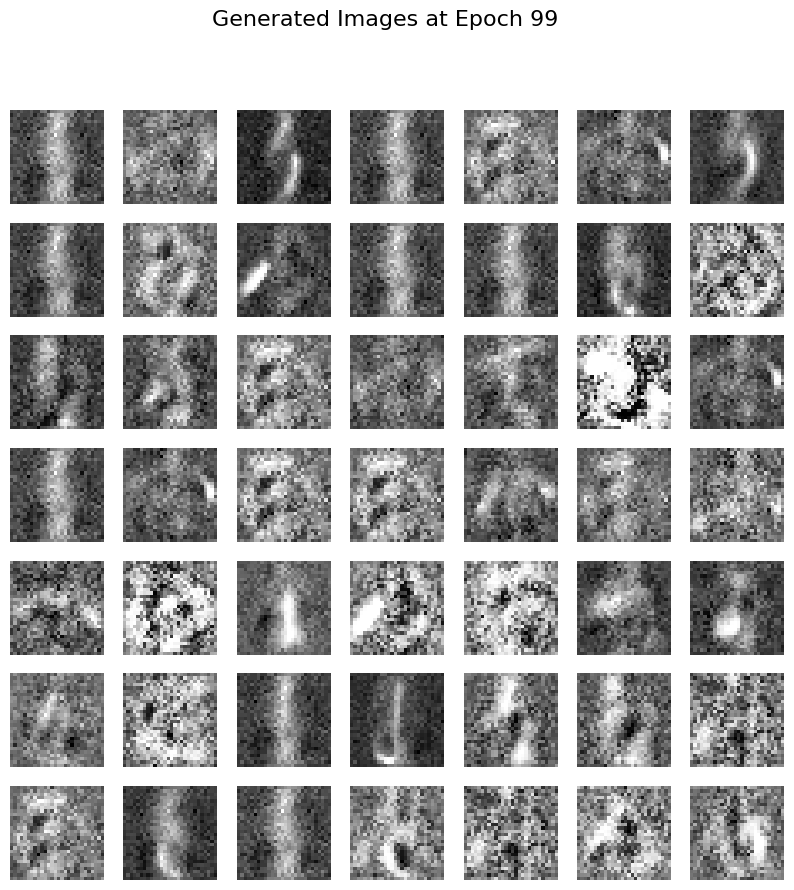

In [9]:
# Training and testing loop with visualization
for epoch in range(epochs):
    train(epoch)
    test(epoch)
    if epoch == 0 or epoch == epochs // 2 or epoch == epochs - 1:
        visualize_generated_images(generator, epoch)

#### Training Plots:

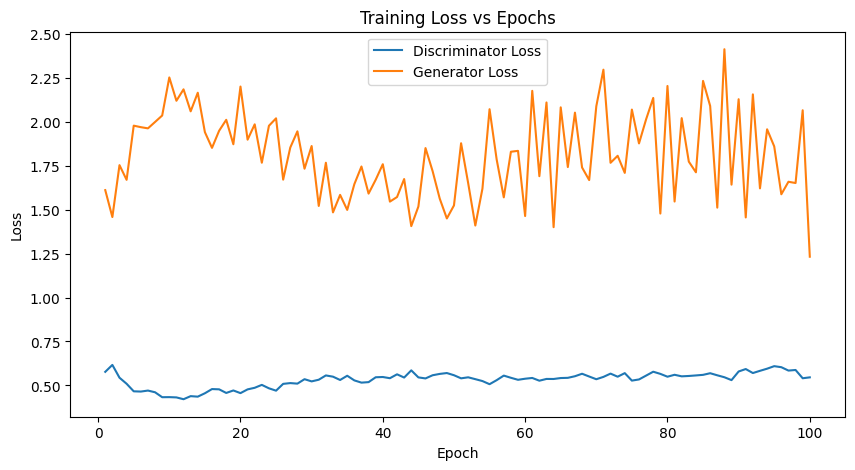

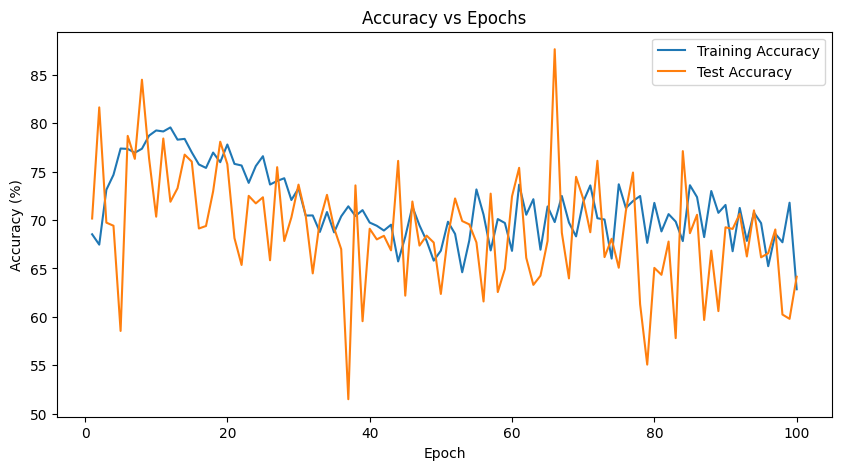

In [10]:
# Plotting losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Discriminator Loss')
plt.plot(range(1, epochs + 1), gen_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss vs Epochs')
plt.show()

# Plotting accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy vs Epochs')
plt.show()


#### Generating characters using trained model:

In [11]:
# Generate and visualize new images
def generate_images(model, num_images, label, style):
    model.eval()
    labels_one_hot = F.one_hot(torch.tensor([label] * num_images), num_classes=label_dim).float().to(device)
    styles = torch.tensor([style] * num_images).reshape(-1, 1).to(device)
    z = torch.randn(num_images, latent_dim).to(device)
    with torch.no_grad():
        generated_imgs = model(z, labels_one_hot, styles).cpu()
    return generated_imgs

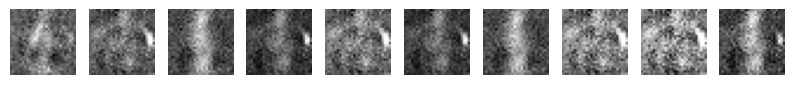

In [12]:
# Example: Generate new images of class 0 with style 'thick' (1)
generated_imgs = generate_images(generator, 10, 0, 1)

# Plot the generated images
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(generated_imgs[i].view(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

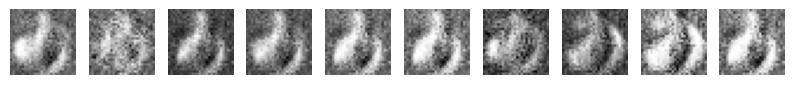

In [13]:
# Example: Generate new images of class 0 with style 'thick' (1)
generated_imgs = generate_images(generator, 10, 0, 0)

# Plot the generated images
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(generated_imgs[i].view(28, 28), cmap='gray')
    plt.axis('off')
plt.show()